This is an example Jupyter notebook on using GELATO.
----------------

First let's import the packages we will need.

In [1]:
# Import packages
import gelato
import numpy as np
%matplotlib inline
from matplotlib import pyplot # For plotting
from astropy.table import Table # For loading in data

We're going to be running our example on the SDSS spectrum, spec-0280-51612-0117.fits, which has a redshift of 0.245. 

In [2]:
# Let's load the spectrum
path_spec = 'Spectra/spec-0280-51612-0117.fits'
spectrum = Table.read(path_spec)

# Start with inverse variance
ivar = spectrum['ivar']
good = ivar > 0 # GELATO only looks at points with nonzero weights

# Finally, let's load in the data
wavl = 10**spectrum['loglam'][good]
flux = spectrum['flux'][good]
ivar = ivar[good]
args = (wavl,flux,ivar) # These will be useful later

Let's go ahead and plot our spectrum to get an idea of what we're dealing with.

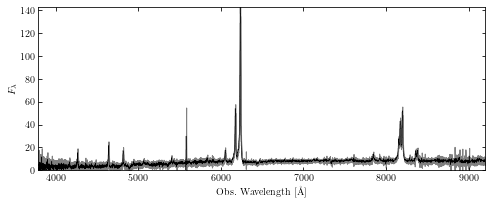

In [3]:
# Create figure
fig, ax = pyplot.subplots(figsize=(8,3))

# Plot Spectrum
sig = 3/np.sqrt(ivar) # 3 Sigma boundary
ax.fill_between(wavl,flux-sig,flux+sig,color='gray')
ax.step(wavl,flux,where='mid',c='k',lw=0.5)

# Axis limits
ax.set(xlim=[wavl.min(),wavl.max()],ylim=[0,flux.max()])

# Axis labels
ax.set(xlabel=r'Obs. Wavelength [\AA]',ylabel=r'$F_\lambda$')

# Show figure
pyplot.show()

The main gelato function takes three inputs.
* The path to the parameters file or the parameters dictionary.
* The path to the spectrum.
* The redshift of the spectrum.

We already have the last two, and we need to take a little precaution with the first.
The main gelato function will only return the final model if the code is being run without multiprocessing (as the return statement can break Python multiprocessing). So we can either change the Parameters JSON file, or edit the parameters dictionary. 

In [4]:
# Path to the parameters file
path_params = './ExampleParameters.json'

# Create Parameters dictionary
params = gelato.ConstructParams.construct(path_params)

# Set to not multiprocessing
params['NProcess'] = 1

We are now ready to run GELATO. Note, before you do this, ensure the results directory exists, either by running the Example from the README file or creating it. 

In [5]:
model = gelato.gelato(params,path_spec,0.245)

Making GELATO for spec-0280-51612-0117.fits
Gathering ingredients: spec-0280-51612-0117.fits
Ingredients gathered: spec-0280-51612-0117.fits
Making the base: spec-0280-51612-0117.fits
Base created: spec-0280-51612-0117.fits
Adding flavor: spec-0280-51612-0117.fits
Flavor added: spec-0280-51612-0117.fits
Scooping portions (this may take a while): spec-0280-51612-0117.fits
Progress: |########################################| 100%
Portions scooped: spec-0280-51612-0117.fits
Presenting GELATO: spec-0280-51612-0117.fits
GELATO presented: spec-0280-51612-0117.fits
Measuring texture: spec-0280-51612-0117.fits
Measured texture: spec-0280-51612-0117.fits
Freezing results: spec-0280-51612-0117.fits
Results freezed: spec-0280-51612-0117.fits
GELATO finished for spec-0280-51612-0117.fits


The results have been saved to the "Results/" Directory. In addition, running GELATO returns the final model created from the fitting with the median of all the boostrap iterations set as the fitted parameters. Let's go ahead and plot the final model.

TypeError: evaluate() missing 3 required positional arguments: 'x', 'y', and 'isig'

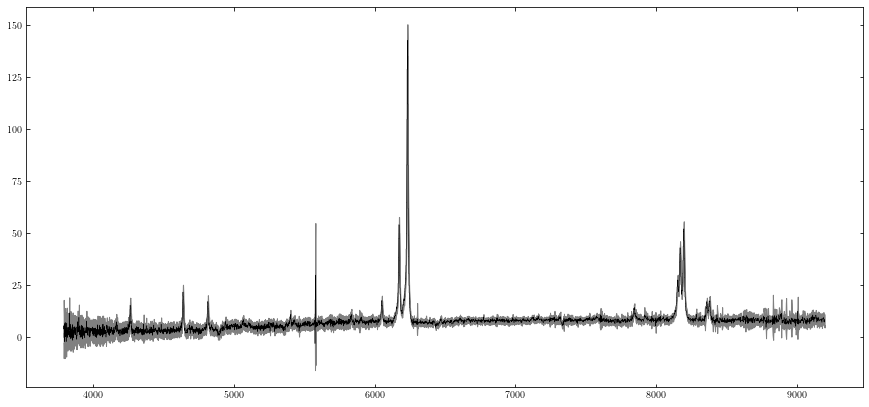

In [7]:
# Create figure
fig, ax = pyplot.subplots(figsize=(15,7))

# Plot Spectrum
ax.fill_between(wavl,flux-sig,flux+sig,color='gray')
ax.step(wavl,flux,where='mid',c='k',lw=0.5,label='Data')
ax.step(wavl,model.evaluate(wavl,*args),where='mid',c='r',label='Model')
ax.legend()

# Axis limits
ax.set(xlim=[wavl.min(),wavl.max()],ylim=[0,flux.max()])

# Axis labels
ax.set(xlabel=r'Obs. Wavelength [\AA]',ylabel=r'$F_\lambda$')

# Show figure
pyplot.show()

That looks pretty good! A quick note, you can only pass the full wavelength range to the model, passing a subset will cause an error. To zoom in, use plotting controls. Now lets take a look at the results table.

In [ ]:
# Load results
results = Table.read('Results/spec-0280-51612-0117-results.fits')
print(results.colnames)

Here we can see all of the fitted model paramters, it's certainly a handful! A quick note, many parameters here are tied together, reducing the degrees of freedom. It's also worth noting the SSP Continuum Redshift and the PL Continuum Center are not fitted, and so are constant throughout all the bootstraps. Let's go ahead and throw this object onto a BPT diagram!

In [ ]:
# Get BPT line fluxes
oiii = results['AGN-[OIII]-5006.84-Flux']
nii = results['AGN-[NII]-6583.45-Flux']
ha = results['Balmer-HI-4861.28-Flux']
hb = results['Balmer-HI-6562.79-Flux']

# Create figure
fig, ax = pyplot.subplots(figsize=(10,10))

# Kewley+ Line
x = np.logspace(-1.5,0.05,100)
y = 10**(0.61/(np.log10(x) - 0.05) + 1.3)
ax.plot(x,y,color='gray',ls='--',label='Kauffman+01')

# Kauffman+ Line
x = np.logspace(-1.5,0.47,100)
y = 10**(0.61/(np.log10(x) - 0.47) + 1.18)
ax.plot(x,y,color='gray',ls=':',label='Kewley+01')

# Plot BPT
ax.scatter(nii/ha,oiii/hb,color='k',label='Bootstraps')
ax.errorbar(np.median(nii/ha),np.median(oiii/hb),np.std(nii/ha),np.std(oiii/hb),color='r',label='Average')
ax.legend()

# Axis limits
ax.set(xlim=[1e-1,1e1],ylim=[1e-1,1e1])

# Axis labels
ax.set(xlabel=r'[NII]/H$\alpha$',ylabel=r'[OIII]/H$\beta$')

# Axis scale
ax.set(yscale='log',xscale='log')

# Show figure
pyplot.show()

And that's all for this short IPython notebook! GELATO is designed to be run through the wrapper scripts, but hopefully this helps if you want to run in an IPython notebook or to help you understand the GELATO output.